In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import statsmodels
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
%matplotlib inline
from pmdarima.arima import auto_arima

In [3]:
# Carregando os dados:
df=pd.read_csv('sea_level.csv')

# Carregando os dados:

df_sea=df.dropna()
df_sea= df_sea.set_index(['Year'])

df_sea.index = pd.to_datetime(df_sea.index, format='%Y')
df_sea = df_sea[['Sea Level']].groupby('Year').sum()
#df_sea.rename(columns={'Sea Level': 'Sea Level'}, inplace = True)

df_sea.head(10)


,Sea Level
Year,
1880-01-01,0.000000
1881-01-01,0.220472
1882-01-01,-0.440945
1883-01-01,-0.232283
1884-01-01,0.590551
1885-01-01,0.531496
1886-01-01,0.437008
1887-01-01,0.216535
1888-01-01,0.299213


In [4]:
df_sea.iloc[[0, -1]]

,Sea Level
Year,
1880-01-01,0.000000
2013-01-01,8.980315


In [7]:
# conhecendo os dados:
df_sea.head(1)

,Sea Level
Year,
1880-01-01,0.0


In [8]:
# conhecendo os dados:
df_sea.tail(1)

,Sea Level
Year,
2013-01-01,8.980315


In [9]:
# conhecendo os dados:
df_sea.info()
df_sea.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1880-01-01 to 2013-01-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sea Level  134 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


,Sea Level
count,134.000000
mean,3.650341
std,2.485692
min,-0.440945
25%,1.632874
50%,3.312992
75%,5.587598
max,9.326772


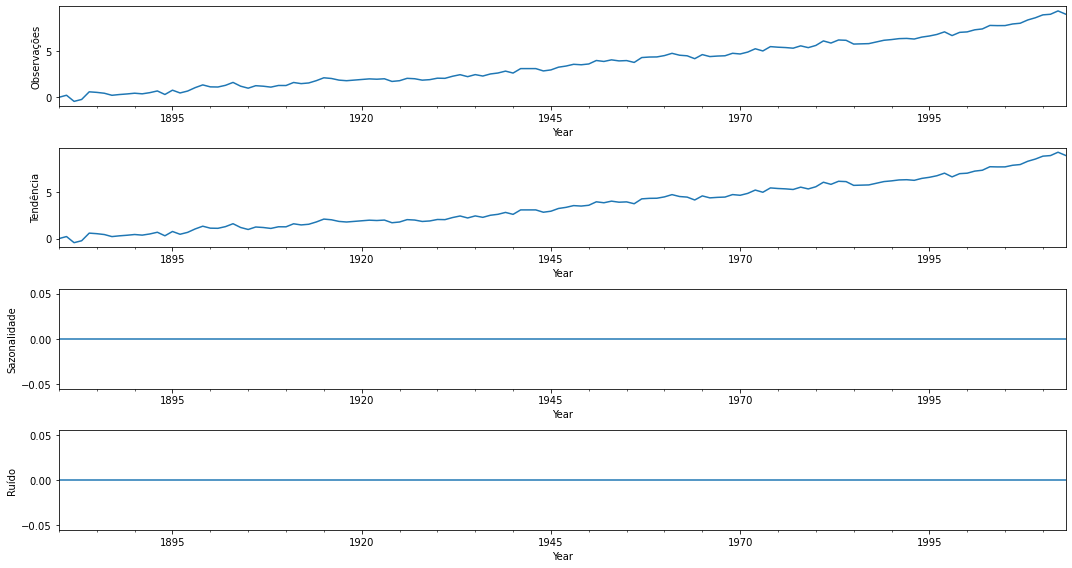

In [10]:
# decompondo a série

seasonplot = seasonal_decompose(df_sea)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1, ylabel='Observações') 
seasonplot.trend.plot(ax=ax2, ylabel='Tendência') 
seasonplot.seasonal.plot(ax=ax3, ylabel='Sazonalidade')
seasonplot.resid.plot(ax=ax4, ylabel='Ruído') 
plt.tight_layout()


In [14]:
# aplicando o teste Dickey-Fuller Aumentado (ADF) para verificar estacionariedade na série:

# Extraindo a coluna que contém os dados da série temporal
dados_serie = df_sea['Sea Level']
resultado_adf = adfuller(dados_serie)

# Extraindo os resultados do teste ADF
valor_p = resultado_adf[1]
estatistica_teste = resultado_adf[0]

# Comparando o valor-p com um nível de significância (geralmente 0.05)
nivel_de_significancia = 0.05

if valor_p <= nivel_de_significancia:
    print("A série temporal é estacionária (rejeita-se a hipótese nula).")
else:
    print("A série temporal não é estacionária (não se rejeita a hipótese nula).")

# Exiba a estatística do teste
print(f"Estatística do teste ADF: {estatistica_teste}")
print(f"Valor-p: {valor_p}")

A série temporal não é estacionária (não se rejeita a hipótese nula).
Estatística do teste ADF: 1.4210821193704959
Valor-p: 0.9972078414167472


In [15]:
# em caso negativo, para teste do melhor resultado da série para se tornar estacionária, pode ser aplicado a diferenciação:
diff_1 = dados_serie.diff().dropna()
# testar novamente por ADF
dados_serie = diff_1
resultado_adf = adfuller(dados_serie)

# Extraindo os resultados do teste ADF
valor_p = resultado_adf[1]
estatistica_teste = resultado_adf[0]

# Comparando o valor-p com um nível de significância (geralmente 0.05)
nivel_de_significancia = 0.05

if valor_p <= nivel_de_significancia:
    print("A série temporal é estacionária (rejeita-se a hipótese nula).")
else:
    print("A série temporal não é estacionária (não se rejeita a hipótese nula).")

# Exiba a estatística do teste
print(f"Estatística do teste ADF: {estatistica_teste}")
print(f"Valor-p: {valor_p}")

A série temporal é estacionária (rejeita-se a hipótese nula).
Estatística do teste ADF: -15.148184710300258
Valor-p: 6.856956707463201e-28


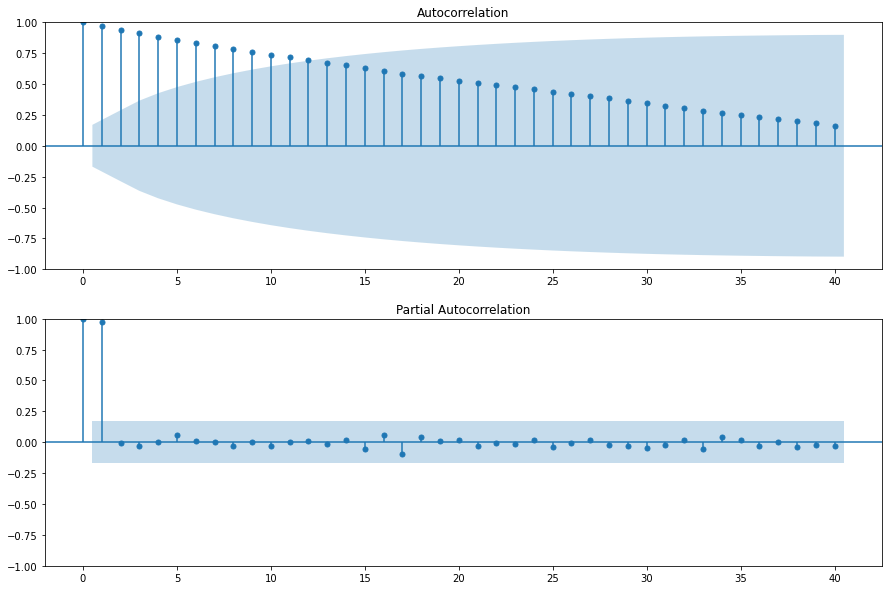

In [17]:
# verificando autocorrelação e autocorrelação parcial:
# auto-regressão (p) = autorrelação; média móvel (q)= autocorrelação parcial.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
sm.graphics.tsa.plot_acf(df_sea.values.squeeze(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df_sea.values.squeeze(), lags= 40, ax=ax2, method='ywm')
plt.show()

In [18]:
# Aplicando método Auto ARIMA (já pode-se definir max e min valores dos parâmetros para facilitar o código):
# A sazonalidade, se mensal, usar m=12; Por padrão o P iniciará em 0 e o máximo será 2; o Q por padrão será 1 e o máximo, por padrão, será 2; o d será 1 e o máximo, por padrão, será 2; o D será 1, por padrão já é 1.
# Serão gerados vários modelos ARIMA e os seus respectivos AIC's e BICS (critérios de informação).
# Stepwise permite diminuir o número de modelos gerados, deixa o código mais leve.
stepwise=auto_arima(df_sea,start_p=0, start_q=0,max_p=3,max_q=2,start_P=0,
                     seasonal=False,trace=True, error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.028, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.182, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26.629, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.749, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-25.833, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-25.869, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22.630, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5.780, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.395 seconds


In [19]:
# verificando resultado e menor AIC:
stepwise

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [20]:
stepwise.aic()

-26.629300105615997

In [129]:
# testando mais um modelo, com parâmetro diferente, por exemplo de sazonalidade D:
stepwise1=auto_arima(df_sea,start_p=0, start_q=0,max_p=5,max_q=5,start_P=0,m=12,
                     seasonal=True,D=1,d=1,trace=True,error_action='ignore',suppress_warnings=True,stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=54.911, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=39.751, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=28.461, Time=0.22 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=19.707, Time=0.82 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=21.697, Time=1.73 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=40.091, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6.110, Time=0.40 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=26.865, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=7.782, Time=1.00 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=13

In [130]:
# verificando demais resultados com menores AIC:
stepwise1
stepwise1.aic()

6.109699495191208

In [131]:
# validar modelo
# separando os dados de treino e teste: os dados de treino (70% inicial da amostra) serão usado para treinar o modelo ARIMA e os dados de teste(30% restante) para comparar com as previsões geradas.

train=df_sea.loc['1880-01-01':'2000-01-01']
test=df_sea.loc['2000-02-01':]

In [132]:
stepwise.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [133]:
stepwise1.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [134]:
# calculando previsões para n periodos futuros:
future_forecast=stepwise.predict(n_periods=24)

In [135]:
future_forecast1=stepwise1.predict(n_periods=24)

In [136]:
future_forecast=pd.DataFrame(future_forecast,index=test.index, columns=['previsão modelo 1'])

In [137]:
future_forecast1=pd.DataFrame(future_forecast1,index=test.index, columns=['previsão modelo 2'])

In [138]:
future_forecast.head(10)

,previsão modelo 1
Year,
2001-01-01,7.090206
2002-01-01,7.149168
2003-01-01,7.208130
2004-01-01,7.267093
2005-01-01,7.326055
2006-01-01,7.385017
2007-01-01,7.443979
2008-01-01,7.502941
2009-01-01,7.561903


In [139]:
future_forecast1.head(10)

,previsão modelo 2
Year,
2001-01-01,7.106960
2002-01-01,7.069372
2003-01-01,7.117429
2004-01-01,7.164252
2005-01-01,7.364663
2006-01-01,7.389594
2007-01-01,7.543829
2008-01-01,7.586448
2009-01-01,7.602078


<Figure size 1440x360 with 0 Axes>

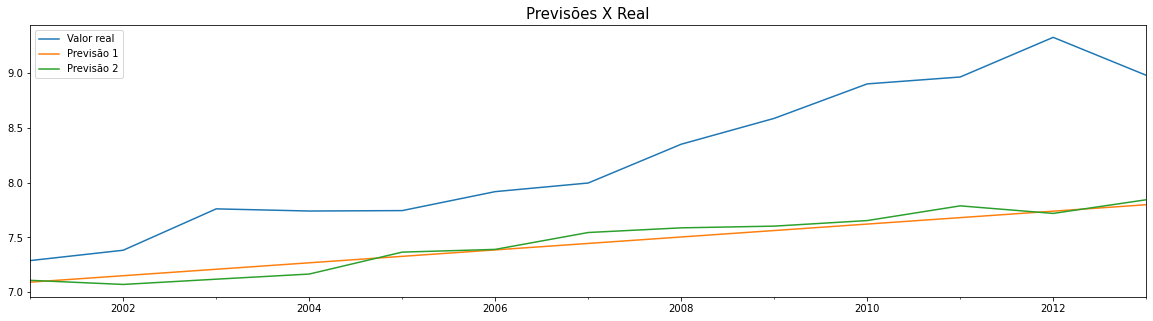

In [140]:
plt.figure(figsize=(20,5))
pd.concat([test,future_forecast, future_forecast1],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.legend(['Valor real','Previsão 1', 'Previsão 2'])
plt.show();

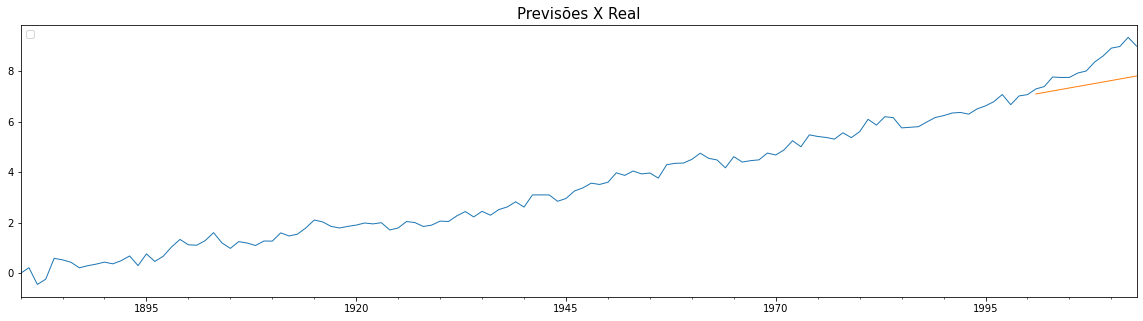

In [141]:
pd.concat([df_sea,future_forecast],axis=1).plot(linewidth=1,figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

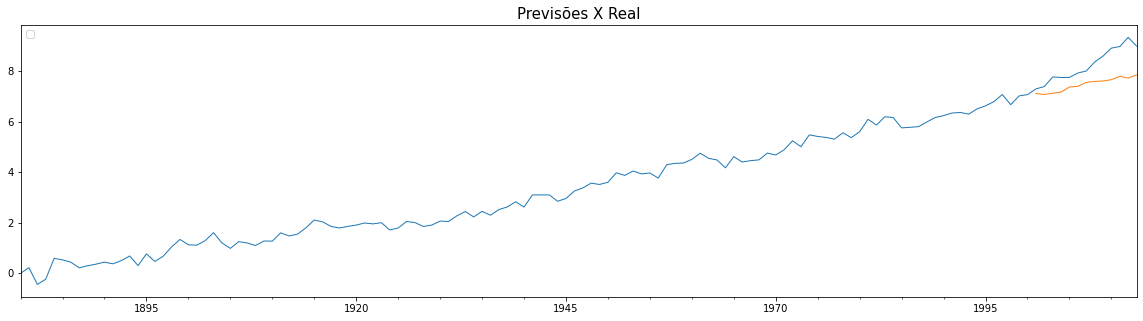

In [142]:
pd.concat([df_sea,future_forecast1],axis=1).plot(linewidth=1, figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

In [143]:
# função para calcular o erro dos modelos
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

In [144]:
# Análise dos erros/resíduos, ideal é o mais próximo de zero
check_erro(test,future_forecast)

,
,
VIÉS,NaN
MSE,0.797173
RMSE,0.892845
MAE,0.781945
MAPE,NaN


In [145]:
check_erro(test,future_forecast1)

,
,
VIÉS,NaN
MSE,0.759998
RMSE,0.871779
MAE,0.768521
MAPE,NaN


In [122]:
erros=pd.DataFrame(np.array(future_forecast.values.tolist())-np.array(test.values.tolist()))

erros1=pd.DataFrame(np.array(future_forecast1.values.tolist())-np.array(test.values.tolist()))

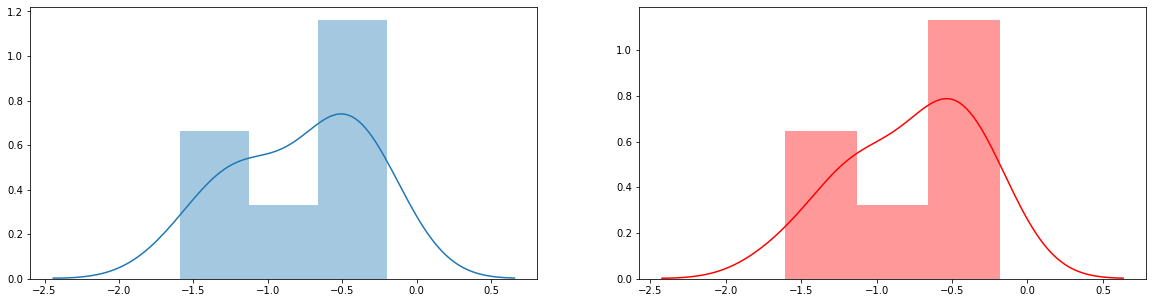

In [123]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(erros,ax=ax[0])
sns.distplot(erros1,ax=ax[1], color='red');

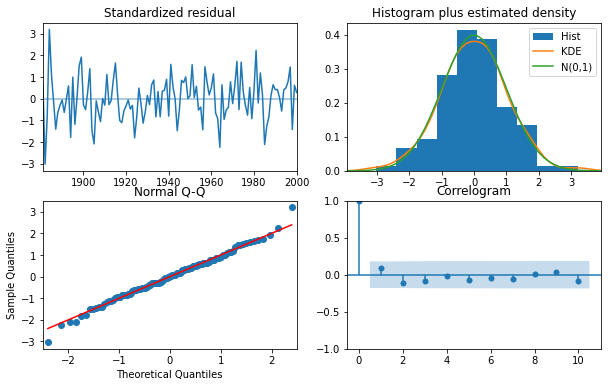

In [124]:
stepwise.plot_diagnostics(figsize=(10,6));

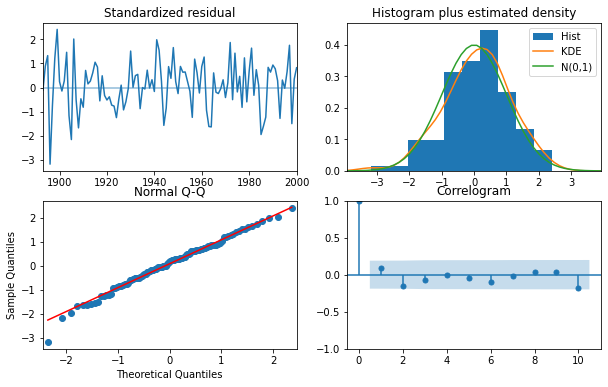

In [125]:
stepwise1.plot_diagnostics(figsize=(10,6));

In [126]:
# Verificado normalidade dos resíduos pelo teste Jarque Bera:
test = jarque_bera(erros)
print('Estatística Jarque-Bera :', test[0])
print('p-valor :', test[1])
print('Assimetria :', test[2])
print('Curtose :',test[3])

Estatística Jarque-Bera : [1.0148861]
p-valor : [0.60203298]
Assimetria : [-0.35610792]
Curtose : [1.8310755]


In [92]:
test1 = jarque_bera(erros1)
print('Estatística Jarque-Bera :', test1[0])
print('p-valor :', test1[1])
print('Assimetria :', test1[2])
print('Curtose :',test1[3])

Estatística Jarque-Bera : [0.86066181]
p-valor : [0.65029388]
Assimetria : [-0.46326748]
Curtose : [2.14533804]


In [93]:
stepwise1.fit(df_sea)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [99]:
future_forecast2=stepwise1.predict(n_periods=48)

In [100]:
uture_forecast2=pd.DataFrame(future_forecast2, 
                              index=pd.date_range(start='2013-01-01',
                                                  end='2017-01-01'),columns=['Nova previsão'])

In [101]:
future_forecast2.head(24)

2014-01-01     9.108369
2015-01-01     9.209449
2016-01-01     9.241986
2017-01-01     9.409754
2018-01-01     9.460907
2019-01-01     9.604859
2020-01-01     9.716347
2021-01-01     9.768674
2022-01-01     9.852881
2023-01-01     9.975075
2024-01-01     9.993264
2025-01-01    10.060868
2026-01-01    10.083234
2027-01-01    10.184314
2028-01-01    10.216851
2029-01-01    10.384619
2030-01-01    10.435772
2031-01-01    10.579724
2032-01-01    10.691212
2033-01-01    10.743539
2034-01-01    10.827746
2035-01-01    10.949940
2036-01-01    10.968129
2037-01-01    11.035733
Freq: AS-JAN, dtype: float64

<Figure size 1440x360 with 0 Axes>

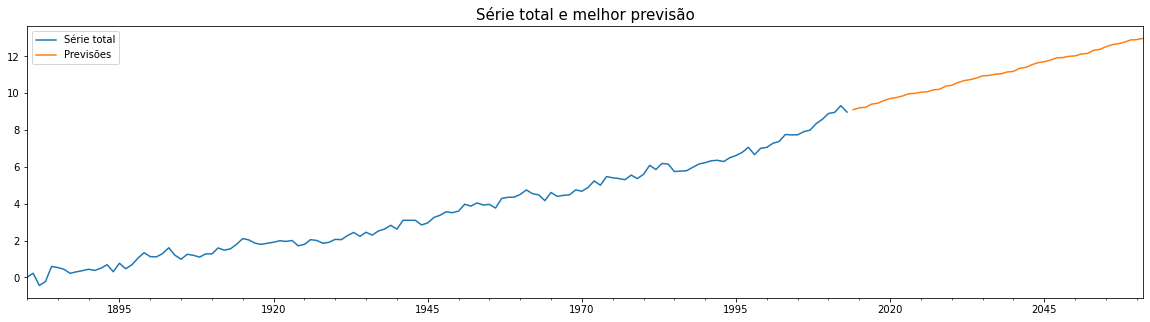

In [127]:
plt.figure(figsize=(20,5))
pd.concat([df_sea,future_forecast2],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Série total e melhor previsão',size=15)
plt.legend(['Série total','Previsões'])
plt.show();